In [1]:
import os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.integrate import odeint
import sys
current_dir = os.path.dirname(os.getcwd())
target_dir = os.path.sep.join(current_dir.split(os.path.sep)[:])
sys.path.append(os.path.join(os.path.dirname(target_dir),'eABCSMC'))
sys.path.append(target_dir)
from Models import *
from EABCSMC import *
from Preconditioning import * 



In [8]:
italy = pd.read_csv('../Data/Sird_bigdata.csv')
italy.fillna(0, inplace = True)

Precond = Preconditioner(SEIRD, 'SEIRD')

Precond.preprocess_data(data=italy, start=0, eff=30, ext=150)
popt, pcov = Precond.fit(p0 = (5.45, 0.44, 0.020, 0.30), bounds=([0, 0, 0, 0], [20, 3, 3,  3]))

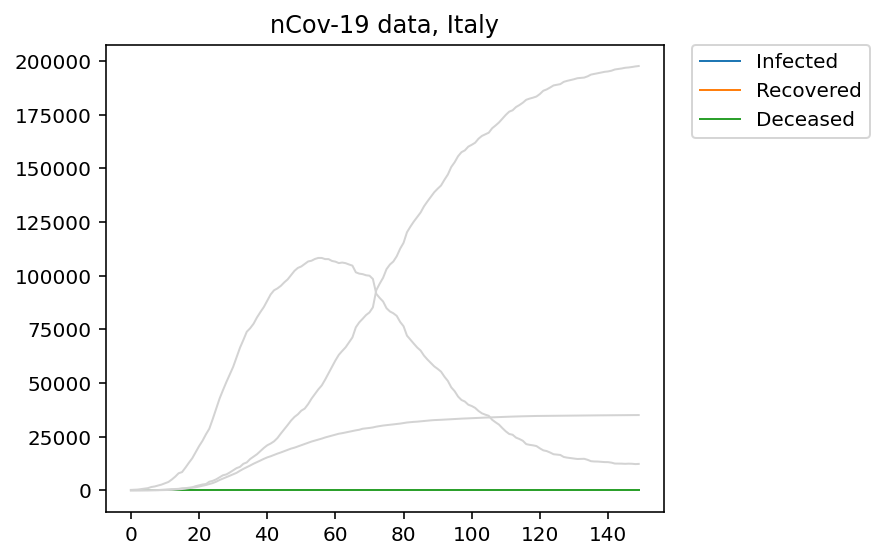

In [9]:
simul_yy =  odeint(SEIRD, (221,7,1,0), np.arange(150), args=tuple(np.reshape(popt,(1,-1))[0]))
plot_traj_SIRD(simul_yy)
plot_traj_gray_SIRD(Precond.extended_y)

In [5]:
extended_yy = np.append(Precond.extended_y[:,0],Precond.extended_y[:,1])
extended_yy = np.append(extended_yy,Precond.extended_y[:,2])

In [6]:
residuals = np.ravel(extended_yy) - Precond.fit_odeint(np.arange(150), *popt)
ss_res = np.sum(residuals**2)

ss_tot = np.sum((np.ravel(extended_yy)-np.ravel(np.mean(extended_yy)))**2)

r_squared = 1 - (ss_res / ss_tot)

r_squared 

0.961574273558905

Text(0.5, 1.0, 'Correlation Matrix')

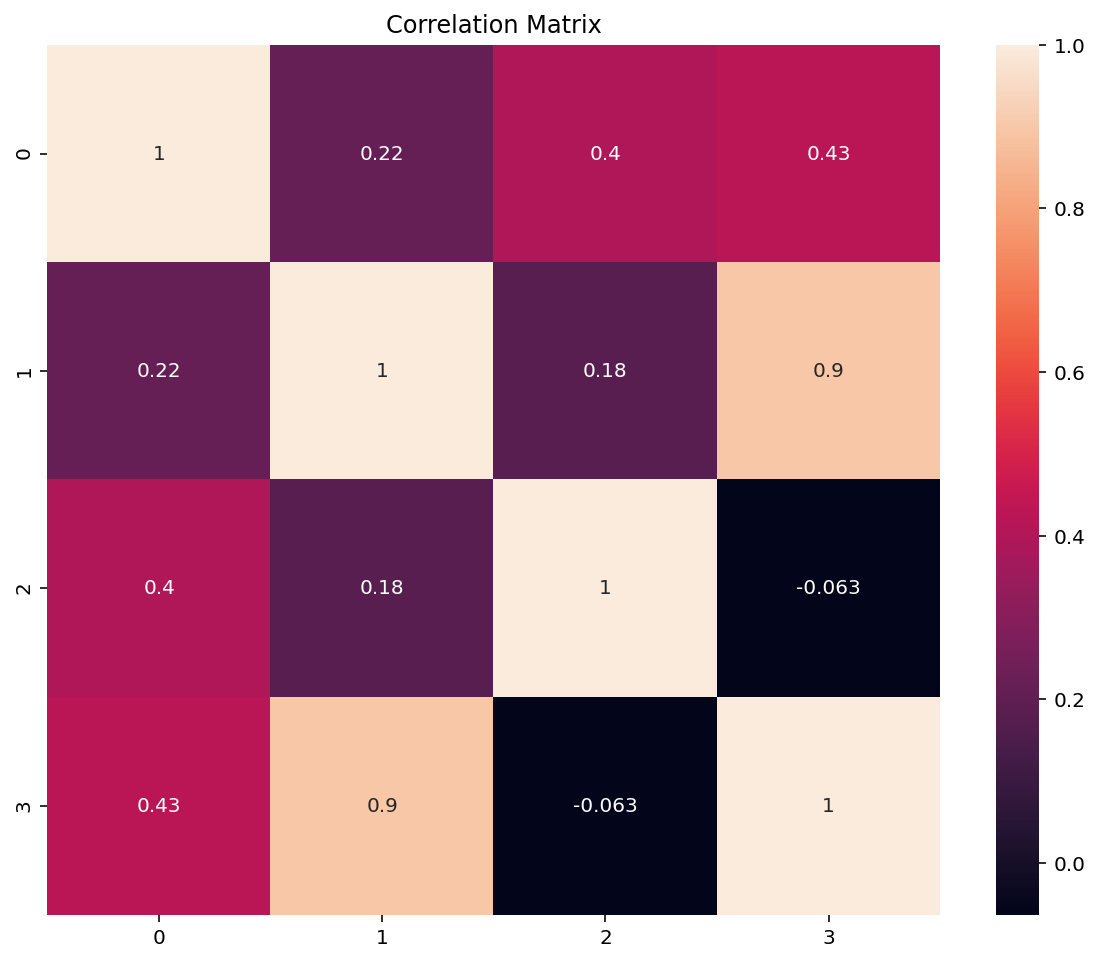

In [7]:
def compute_corr(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

import seaborn as sns

corr = compute_corr(pcov)

plt.figure(figsize=(10,8))

sns.heatmap(corr, annot = True)

plt.title("Correlation Matrix")


In [8]:
lambda_ranges = [lambda : npr.uniform(low = 0.5, high = 5), lambda: npr.uniform(low = 0.5, high = 5), lambda: npr.uniform(low = 0.5, high = 5),
                lambda: npr.uniform(low = 0.5, high = 5)]
prior_means =  np.array([5, 0.388,  0.02922435,  0.30892933])

Sampler = EABCSMCSampler(true_y = Precond.true_yy, ODEmodel = Precond.fit_odeint, num_param = len(popt), numerical_estimate = popt, final_time = 30, 
                         prior_means = prior_means, lambda_ranges = lambda_ranges, n_jobs = 3)

In [9]:
lambda_ranges

[<function __main__.<lambda>()>,
 <function __main__.<lambda>()>,
 <function __main__.<lambda>()>,
 <function __main__.<lambda>()>]

  0%|                                                                                        | 0/30000 [00:00<?, ?it/s]

Borders estimation start...


  0%|▏                                                                             | 30/15000 [00:00<00:51, 289.23it/s]

Acceptance rate:  0.004533333333333334
Borders estimation completed, starting preprocessing...
Borders: [1.6634444140451947, 0.3880986183187019, 0.0047821376955034176, 0.0021375544682363384]


  0%|                                                                               | 12/15000 [00:00<03:10, 78.64it/s]

Acceptance rate:  0.0032
Preprocessing completed, starting ABC-SMC


  0%|▏                                                                             | 30/15000 [00:00<01:03, 235.00it/s]

Acceptance rate:  0.0224
ABS-SMC round :  2


  0%|                                                                               | 12/90000 [00:00<15:34, 96.26it/s]

Acceptance rate:  0.0112
ABS-SMC round :  3


100%|███████████████████████████████████████████████████████████████████████████| 90000/90000 [08:03<00:00, 186.01it/s]


Acceptance rate:  0.007577777777777778


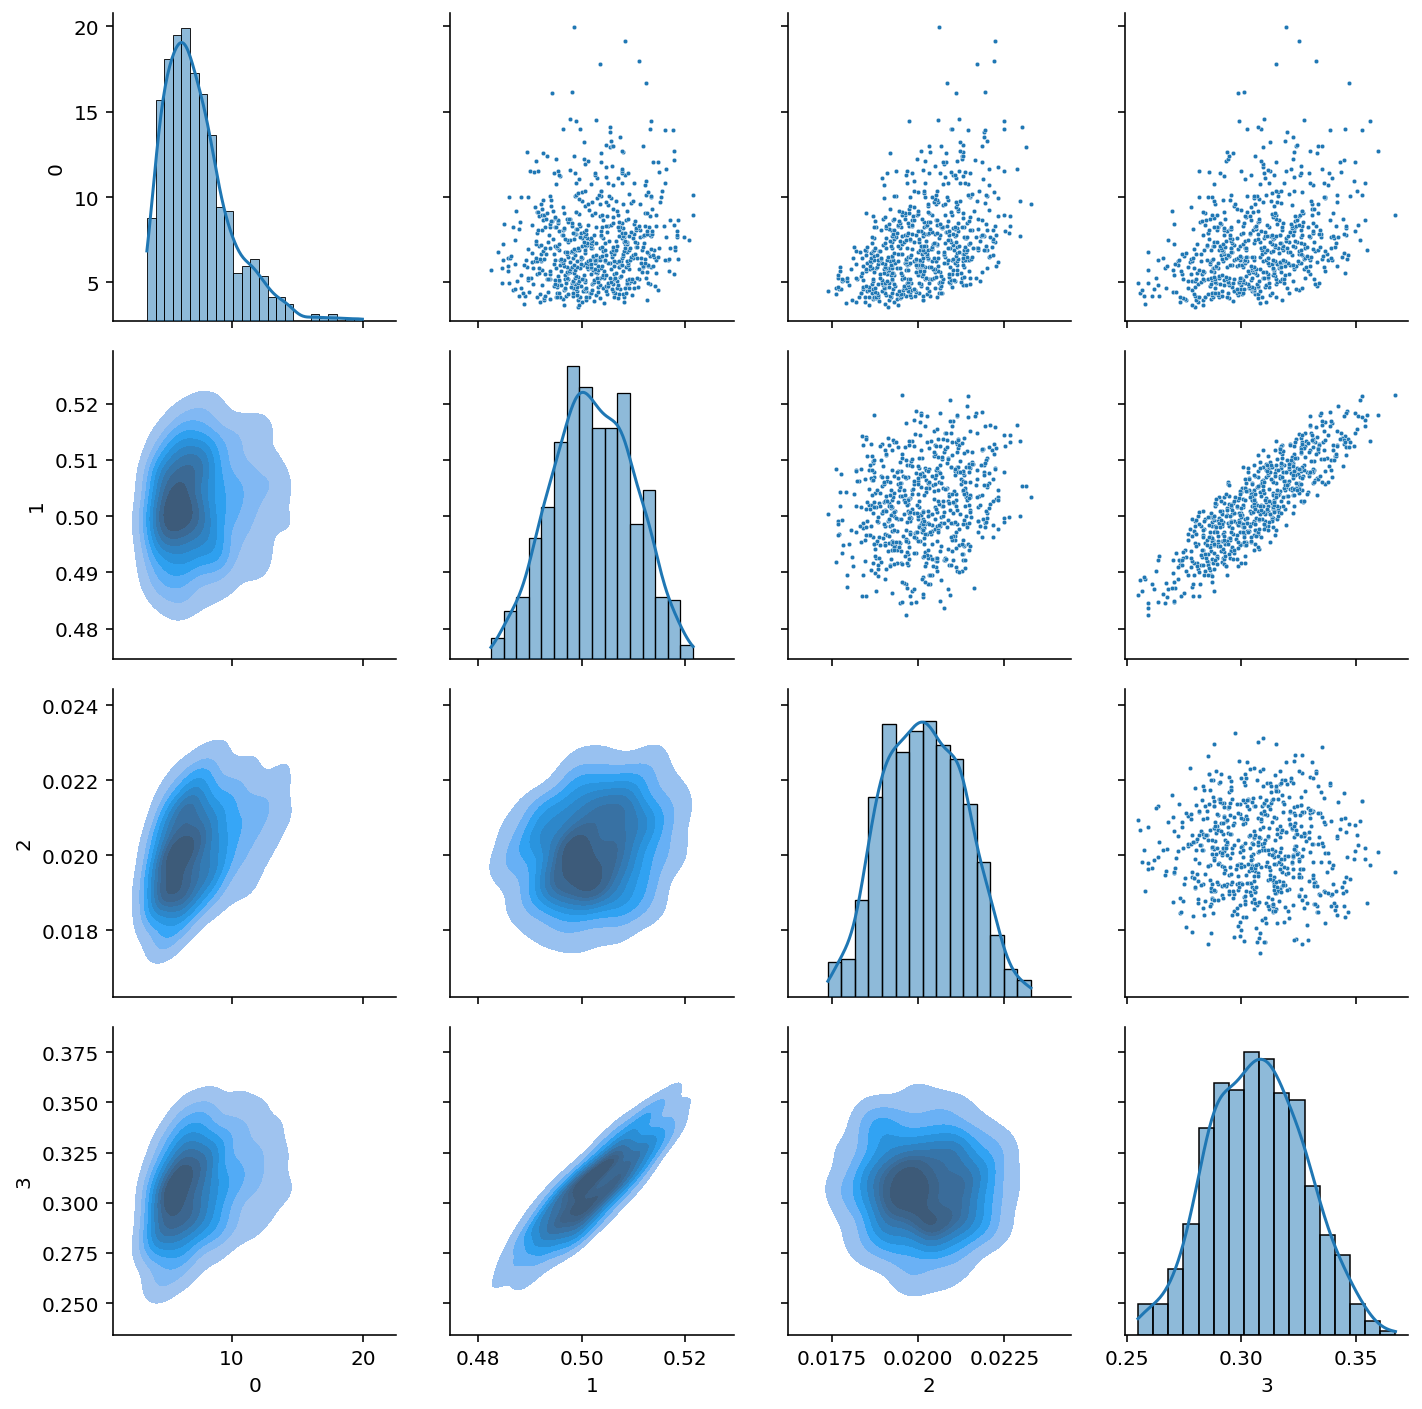

In [24]:
npr.seed(42)
Sampler.fit(niters=3000, eps_schedule=[2, 1, 1/2, 1/4, 1/8], niters_schedule=[10, 5, 5, 5, 30])
Sampler.pairplot()

In [29]:
params =parameters

In [25]:
parameters = Sampler.parameters

In [21]:
def plot_traj_SIRD(trajectories, width=1.5):
    x2 = trajectories[:, 0]
    x3 = trajectories[:, 1]
    x4 = trajectories[:, 2]

    i = plt.plot(x2, linewidth=width, label='Infected', color = 'navy')
    r = plt.plot(x3, linewidth=width, label='Recovered', color = (.21,.39,.55))
    d = plt.plot(x4, linewidth=width, label='Deceased', color = (0.39,.72,1))

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # plt.title('Real SIRD')
    plt.title('SEIRD prediction at day 30')
    plt.tight_layout()
    
def plot_traj_SIRD2(trajectories, width=.7):
    x2 = trajectories[:, 0]
    x3 = trajectories[:, 1]
    x4 = trajectories[:, 2]
    color_ = (0,0,0.5)
    

    i = plt.plot(x2, linewidth=width,color = 'navy', linestyle = 'dashed' )
    r = plt.plot(x3, linewidth=width, color = (.21,.39,.55), linestyle = 'dashed')
    d = plt.plot(x4, linewidth=width,  color = (0.39,.72,1), linestyle = 'dashed')

    # plt.title('Real SIRD')
    plt.tight_layout()

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 57.00it/s]


102312.05821942986 143552.4062576201
52.0 58.0
55
108257.0


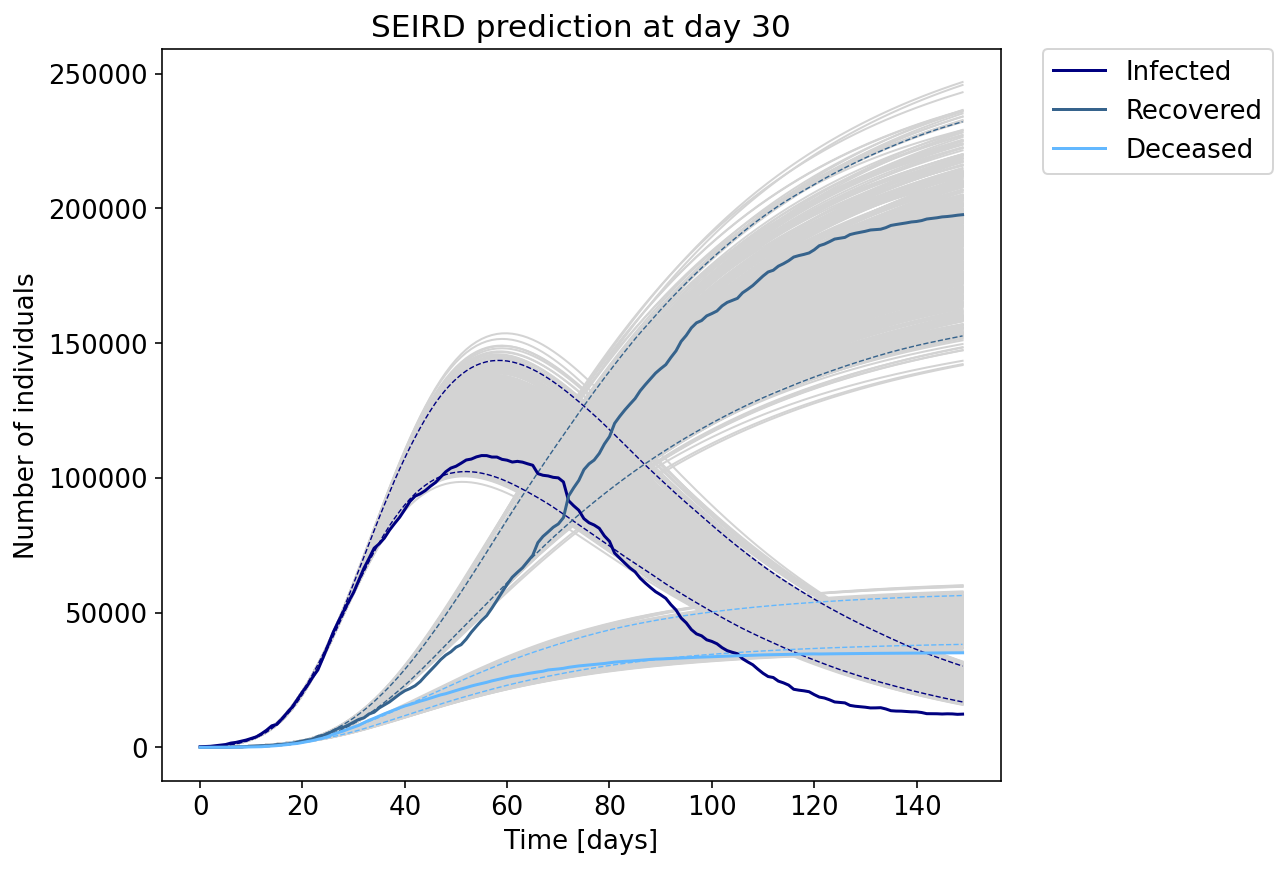

<Figure size 432x288 with 0 Axes>

In [22]:
# magari anche questo lo metto dentro all'abc sampler

fig = plt.figure(figsize = (9,6))

plt.rcParams.update({'font.size': 13})


peak = []
day_peak = []
simul_all = []

for j in tqdm(range(parameters.shape[0])):
    simul_yy =  odeint(SEIRD, [221,1,7,0], np.arange(150), args=tuple(parameters[j]))
    simul_all.append(simul_yy)
    plot_traj_gray_SIRD(simul_yy)
    peak.append(max(simul_yy[:,0]))
    day_peak.append(np.argmax(simul_yy[:,0]))

simul_all = np.array(simul_all)
q95 = []
q05 = []
mean = []
sd = []
for i in range(150):
    q95.append([np.quantile(simul_all[:,i,0],0.975),np.quantile(simul_all[:,i,1],0.975),np.quantile(simul_all[:,i,2],0.975)])
    q05.append([np.quantile(simul_all[:,i,0],0.025),np.quantile(simul_all[:,i,1],0.025),np.quantile(simul_all[:,i,2],0.025)])
    mean.append([np.mean(simul_all[:,i,0]),np.mean(simul_all[:,i,1]),np.mean(simul_all[:,i,2])])
    sd.append([np.std(simul_all[:,i,0]),np.std(simul_all[:,i,1]),np.std(simul_all[:,i,2])])

q95 = np.array(q95)    
q05 = np.array(q05)  

plot_traj_SIRD2(q95)

plot_traj_SIRD2(q05)

plot_traj_SIRD(Precond.extended_y)

print(np.quantile(peak,0.025), np.quantile(peak,0.975))
print(np.quantile(day_peak,0.025), np.quantile(day_peak,0.975))
print(np.argmax(Precond.extended_y[:,0]))
print(np.max(Precond.extended_y[:,0]))

plt.ylabel('Number of individuals')
plt.xlabel('Time [days]')
plt.show()

In [74]:
PBR = 0
for i in range(31,150):
    PBR += np.sum([(Precond.extended_y[i][j] - mean[i][j] / sd[i][j])**2 for j in range(2)])

In [75]:
PBR

2825534166995.441

In [76]:
PBR / 2825480187584.038

1.0000191045089044

10 11


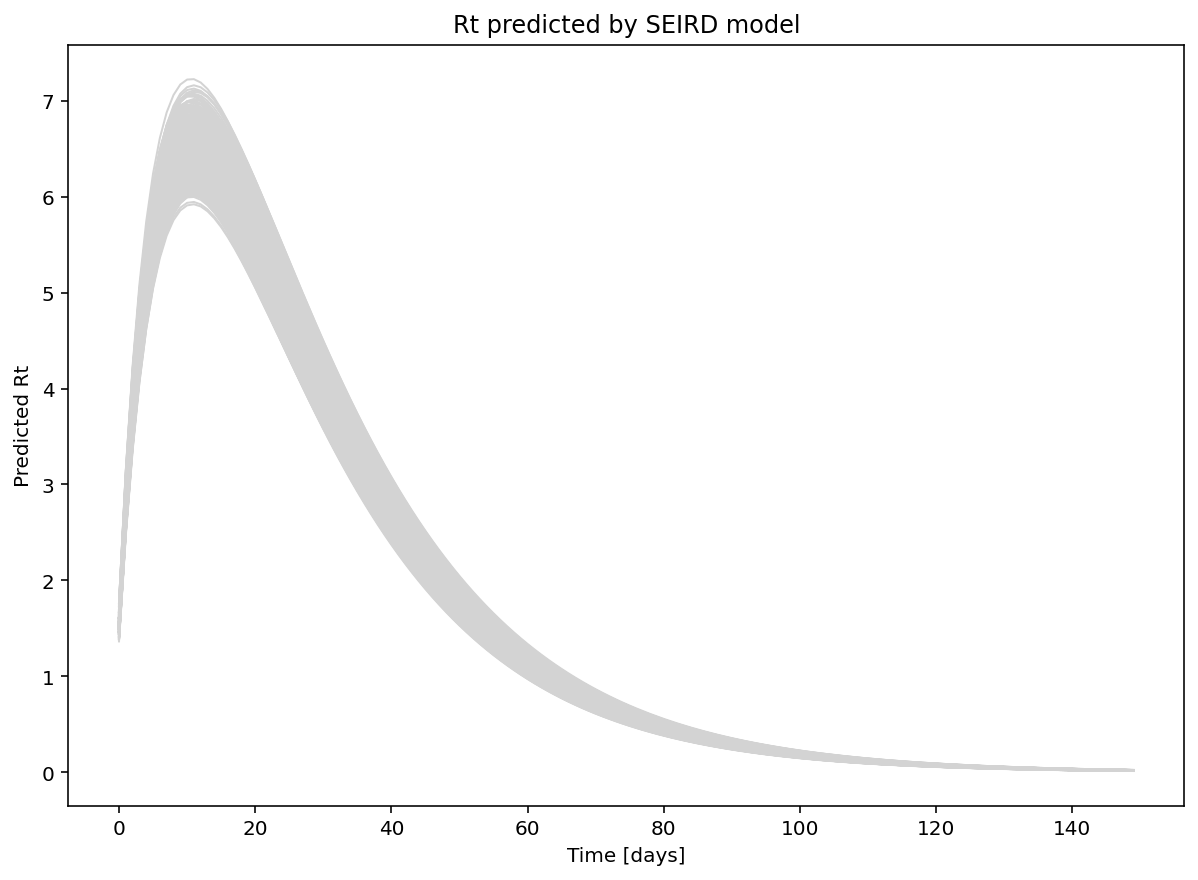

In [94]:
t = np.arange(150)

fig = plt.figure(figsize = (10,7))

day_max = []

for j in range(parameters.shape[0]):
    plt.plot(t, parameters[j,1]* np.exp(-(0.0952 * parameters[j,1]) * t)/((parameters[j,3]/(t+1)) + parameters[j,2]), linewidth = 1, color = 'lightgray')
    day_max.append(np.argmax(parameters[j,1]* np.exp(-(0.0952 * parameters[j,1]) * t)/((parameters[j,3]/(t+1)) + parameters[j,2])))
    
plt.title('Rt predicted by SEIRD model')
plt.ylabel('Predicted Rt')
plt.xlabel('Time [days]')
print(min(day_max), max(day_max))  